In [7]:
import numpy as np
import tensorflow as tf
import tempfile
import matplotlib.pyplot as plt

tf.logging.set_verbosity(tf.logging.INFO)

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
mnist.train.num_examples, mnist.test.num_examples

(55000, 10000)

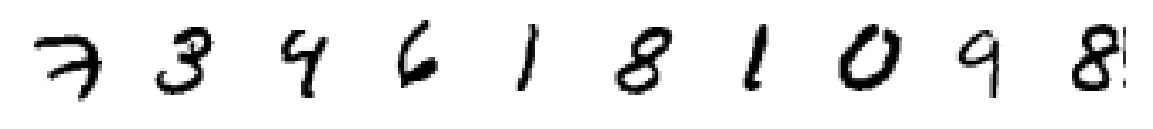

In [10]:
n_samples = 10
plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = mnist.train.images[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")
plt.show()

### Build the graph

In [11]:
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

In [13]:
x_image = tf.reshape(x, [-1, 28, 28, 1])

Convenience functions

In [14]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)


In [15]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

Layer 1

In raw tensorflow, we don't specify the number of neurons in a layer. <br />
Instead, this follows from the shape of the weights matrix.

This is more easily visible with the fully connected layers below.

In [16]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

In [17]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

Layer 2

In [18]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

In [19]:
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

Layer 3

In [20]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

In [21]:
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

Dropout

In [22]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Layer 4

In [23]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

In [24]:
y_pred = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

Loss

In [25]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_pred))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



Optimizer

In [26]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

Accuracy

In [27]:
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


Save the graph

In [28]:
graph_location = tempfile.mkdtemp()
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph())

Saving graph to: /tmp/tmpxxgfo7_g


### Run the graph and evaluate on test set

In [29]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(1000):
    batch = mnist.train.next_batch(50)
    if i % 100 == 0:
      train_accuracy = accuracy.eval(feed_dict={x: batch[0], y: batch[1], keep_prob: 1.0})
      print('step %d, training accuracy %g' % (i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y: batch[1], keep_prob: 0.5})    
  
  print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0}))


step 0, training accuracy 0.06
step 100, training accuracy 0.9
step 200, training accuracy 0.9
step 300, training accuracy 0.88
step 400, training accuracy 1
step 500, training accuracy 0.98
step 600, training accuracy 0.96
step 700, training accuracy 0.96
step 800, training accuracy 0.96
step 900, training accuracy 0.94
test accuracy 0.9668
